<a href="https://colab.research.google.com/github/carloscastillo10/predicting-academic-performance/blob/main/jul-2023/normalized-data/experiment-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Escenario 3: Reajuste de experimentos en base al tratamiento de las clases desbalanceadas**

## Experimento 1: Eliminación de variables que generan ruido

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_columns = 50

In [ ]:
outliers = [
    'numero_reprobaciones',
    'porcentaje_de_discapacidades',
    'discapacidad',
    'numero_discapacidades',
    'final_nota',
    'final_ponderado'
]

In [ ]:
def read_data():
    return pd.read_csv('data/numerical-data-with-best-predictors.csv').drop(outliers, axis = 1)

In [ ]:
numeric_data = read_data()
numeric_data['edad'] = numeric_data['edad'].replace(-1, np.nan)
mode = numeric_data['edad'].mode().values[0]
numeric_data['edad'] = numeric_data['edad'].fillna(mode)

In [ ]:
numeric_data.head()

,provincia,canton,edad,sexo,status,aab1_nota,aab1_ponderado,acdb1_nota,acdb1_ponderado,apeb1_nota,apeb1_ponderado,aab2_nota,aab2_ponderado,acdb2_nota,acdb2_ponderado,apeb2_nota,apeb2_ponderado,tasa_aprobacion
0,17,137,24.0,1,0,8.71,30.49,10.0,35.0,10.00,30.00,8.91,31.19,10.00,35.00,5.00,15.00,0.83
1,17,137,24.0,1,0,8.03,28.10,10.0,35.0,8.67,26.01,5.11,17.89,9.57,33.49,8.37,25.11,0.83
2,17,137,24.0,1,0,7.69,26.92,10.0,35.0,9.17,27.51,7.31,25.59,10.00,35.00,8.83,26.49,1.00
3,17,137,24.0,1,0,5.63,19.70,10.0,35.0,5.07,15.21,6.03,21.11,9.57,33.49,10.00,30.00,0.50
4,17,137,24.0,1,0,7.54,26.39,10.0,35.0,8.77,26.31,7.46,26.11,8.00,28.00,8.50,25.50,1.00


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Variables independientes
numeric_x = numeric_data.drop('status', axis = 1)

# Variables dependientes
numeric_y = numeric_data['status']

# Data de entrenamiento = 70%
# Data de prueba = 30%
numeric_x_train, numeric_x_test, numeric_y_train, numeric_y_test = train_test_split(numeric_x, numeric_y, test_size = 0.3, random_state = 0)

## Normalizar datos

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
numeric_x_train_scaler = scaler.fit_transform(numeric_x_train)
numeric_x_test_scaler = scaler.fit_transform(numeric_x_test)
numeric_y_train_scaler = scaler.fit_transform(numeric_y_train.values.reshape(-1, 1))
numeric_y_test_scaler = scaler.fit_transform(numeric_y_test.values.reshape(-1, 1))

## **Modelo 1: Regresión Logística**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
scaler = MinMaxScaler()
numeric_x_train_scaler = scaler.fit_transform(numeric_x_train)
numeric_x_test_scaler = scaler.fit_transform(numeric_x_test)

In [ ]:
logistic_regresion_model = LogisticRegression(random_state = 0)
logistic_regresion_model.fit(numeric_x_train_scaler, numeric_y_train)
predictions = logistic_regresion_model.predict(numeric_x_test_scaler)

In [ ]:
import statsmodels.api as sm
from scipy import stats

In [ ]:
X2 = sm.add_constant(numeric_x_train_scaler)
est = sm.OLS(numeric_y_train_scaler, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 status   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1070.
Date:                Thu, 03 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:35:04   Log-Likelihood:                -940.03
No. Observations:               16480   AIC:                             1912.
Df Residuals:                   16464   BIC:                             2035.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2574      0.018     

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
accuracy = logistic_regresion_model.score(numeric_x_train_scaler, numeric_y_train)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.9290655339805826


In [ ]:
print(classification_report(numeric_y_test_scaler, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.94      0.97      0.96      5929
   Reprobado       0.82      0.67      0.74      1134

    accuracy                           0.92      7063
   macro avg       0.88      0.82      0.85      7063
weighted avg       0.92      0.92      0.92      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.671958
Reprobado,0.971327


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,6131
Reprobado,1134,932


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

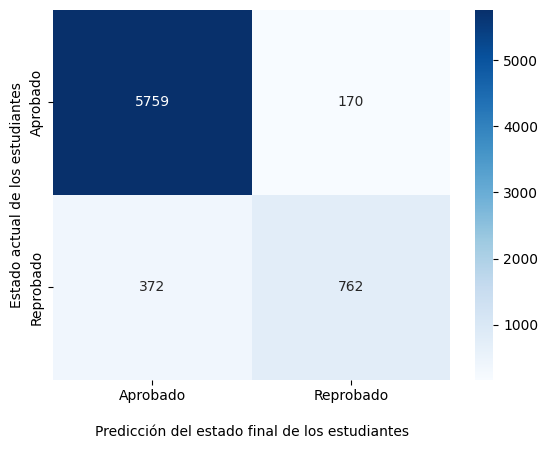

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

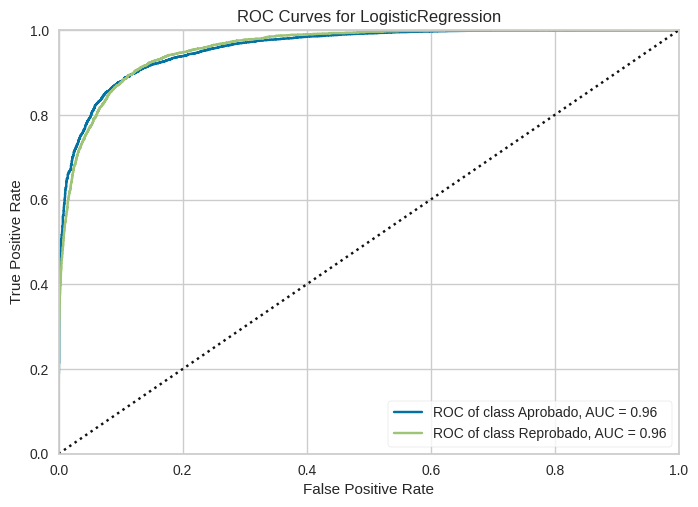

In [ ]:
visualizer = ROCAUC(
    logistic_regresion_model,
    macro = False,
    micro = False,
    encoder = {0: 'Aprobado', 1: 'Reprobado'},
)
visualizer.fit(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.score(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.finalize()

In [ ]:
auc_logistic_regression = visualizer

## **Modelo 2: Análisis Discriminante Lineal**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit_transform(numeric_x_train_scaler, numeric_y_train)
predictions = lda_model.predict(numeric_x_test_scaler)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
accuracy = lda_model.score(numeric_x_train_scaler, numeric_y_train_scaler)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.9268810679611651


In [ ]:
print(classification_report(numeric_y_test_scaler, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.94      0.97      0.95      5929
   Reprobado       0.80      0.67      0.73      1134

    accuracy                           0.92      7063
   macro avg       0.87      0.82      0.84      7063
weighted avg       0.92      0.92      0.92      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.672840
Reprobado,0.967448


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,6107
Reprobado,1134,956


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

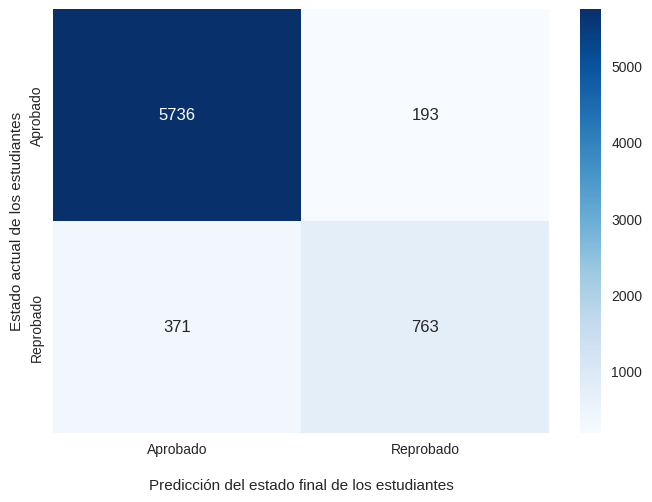

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

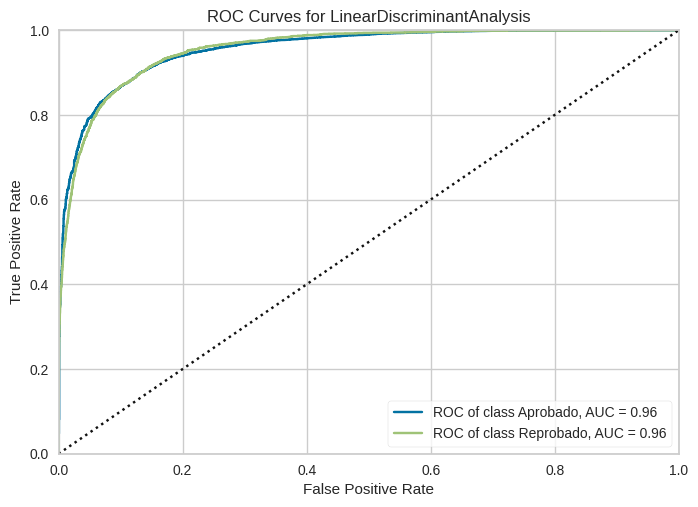

In [ ]:
visualizer = ROCAUC(
    lda_model,
    macro = False,
    micro = False,
    encoder = {0: 'Aprobado', 1: 'Reprobado'},
)
visualizer.fit(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.score(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.finalize()

In [ ]:
auc_lineal_discriminant = visualizer

## **Modelo 3: Bosque aleatorio**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [ ]:
rand_forest_classifier_model = RandomForestClassifier(random_state = 0, max_depth = 5)
rand_forest_classifier_model.fit(numeric_x_train_scaler, numeric_y_train)
predictions = rand_forest_classifier_model.predict(numeric_x_test_scaler)

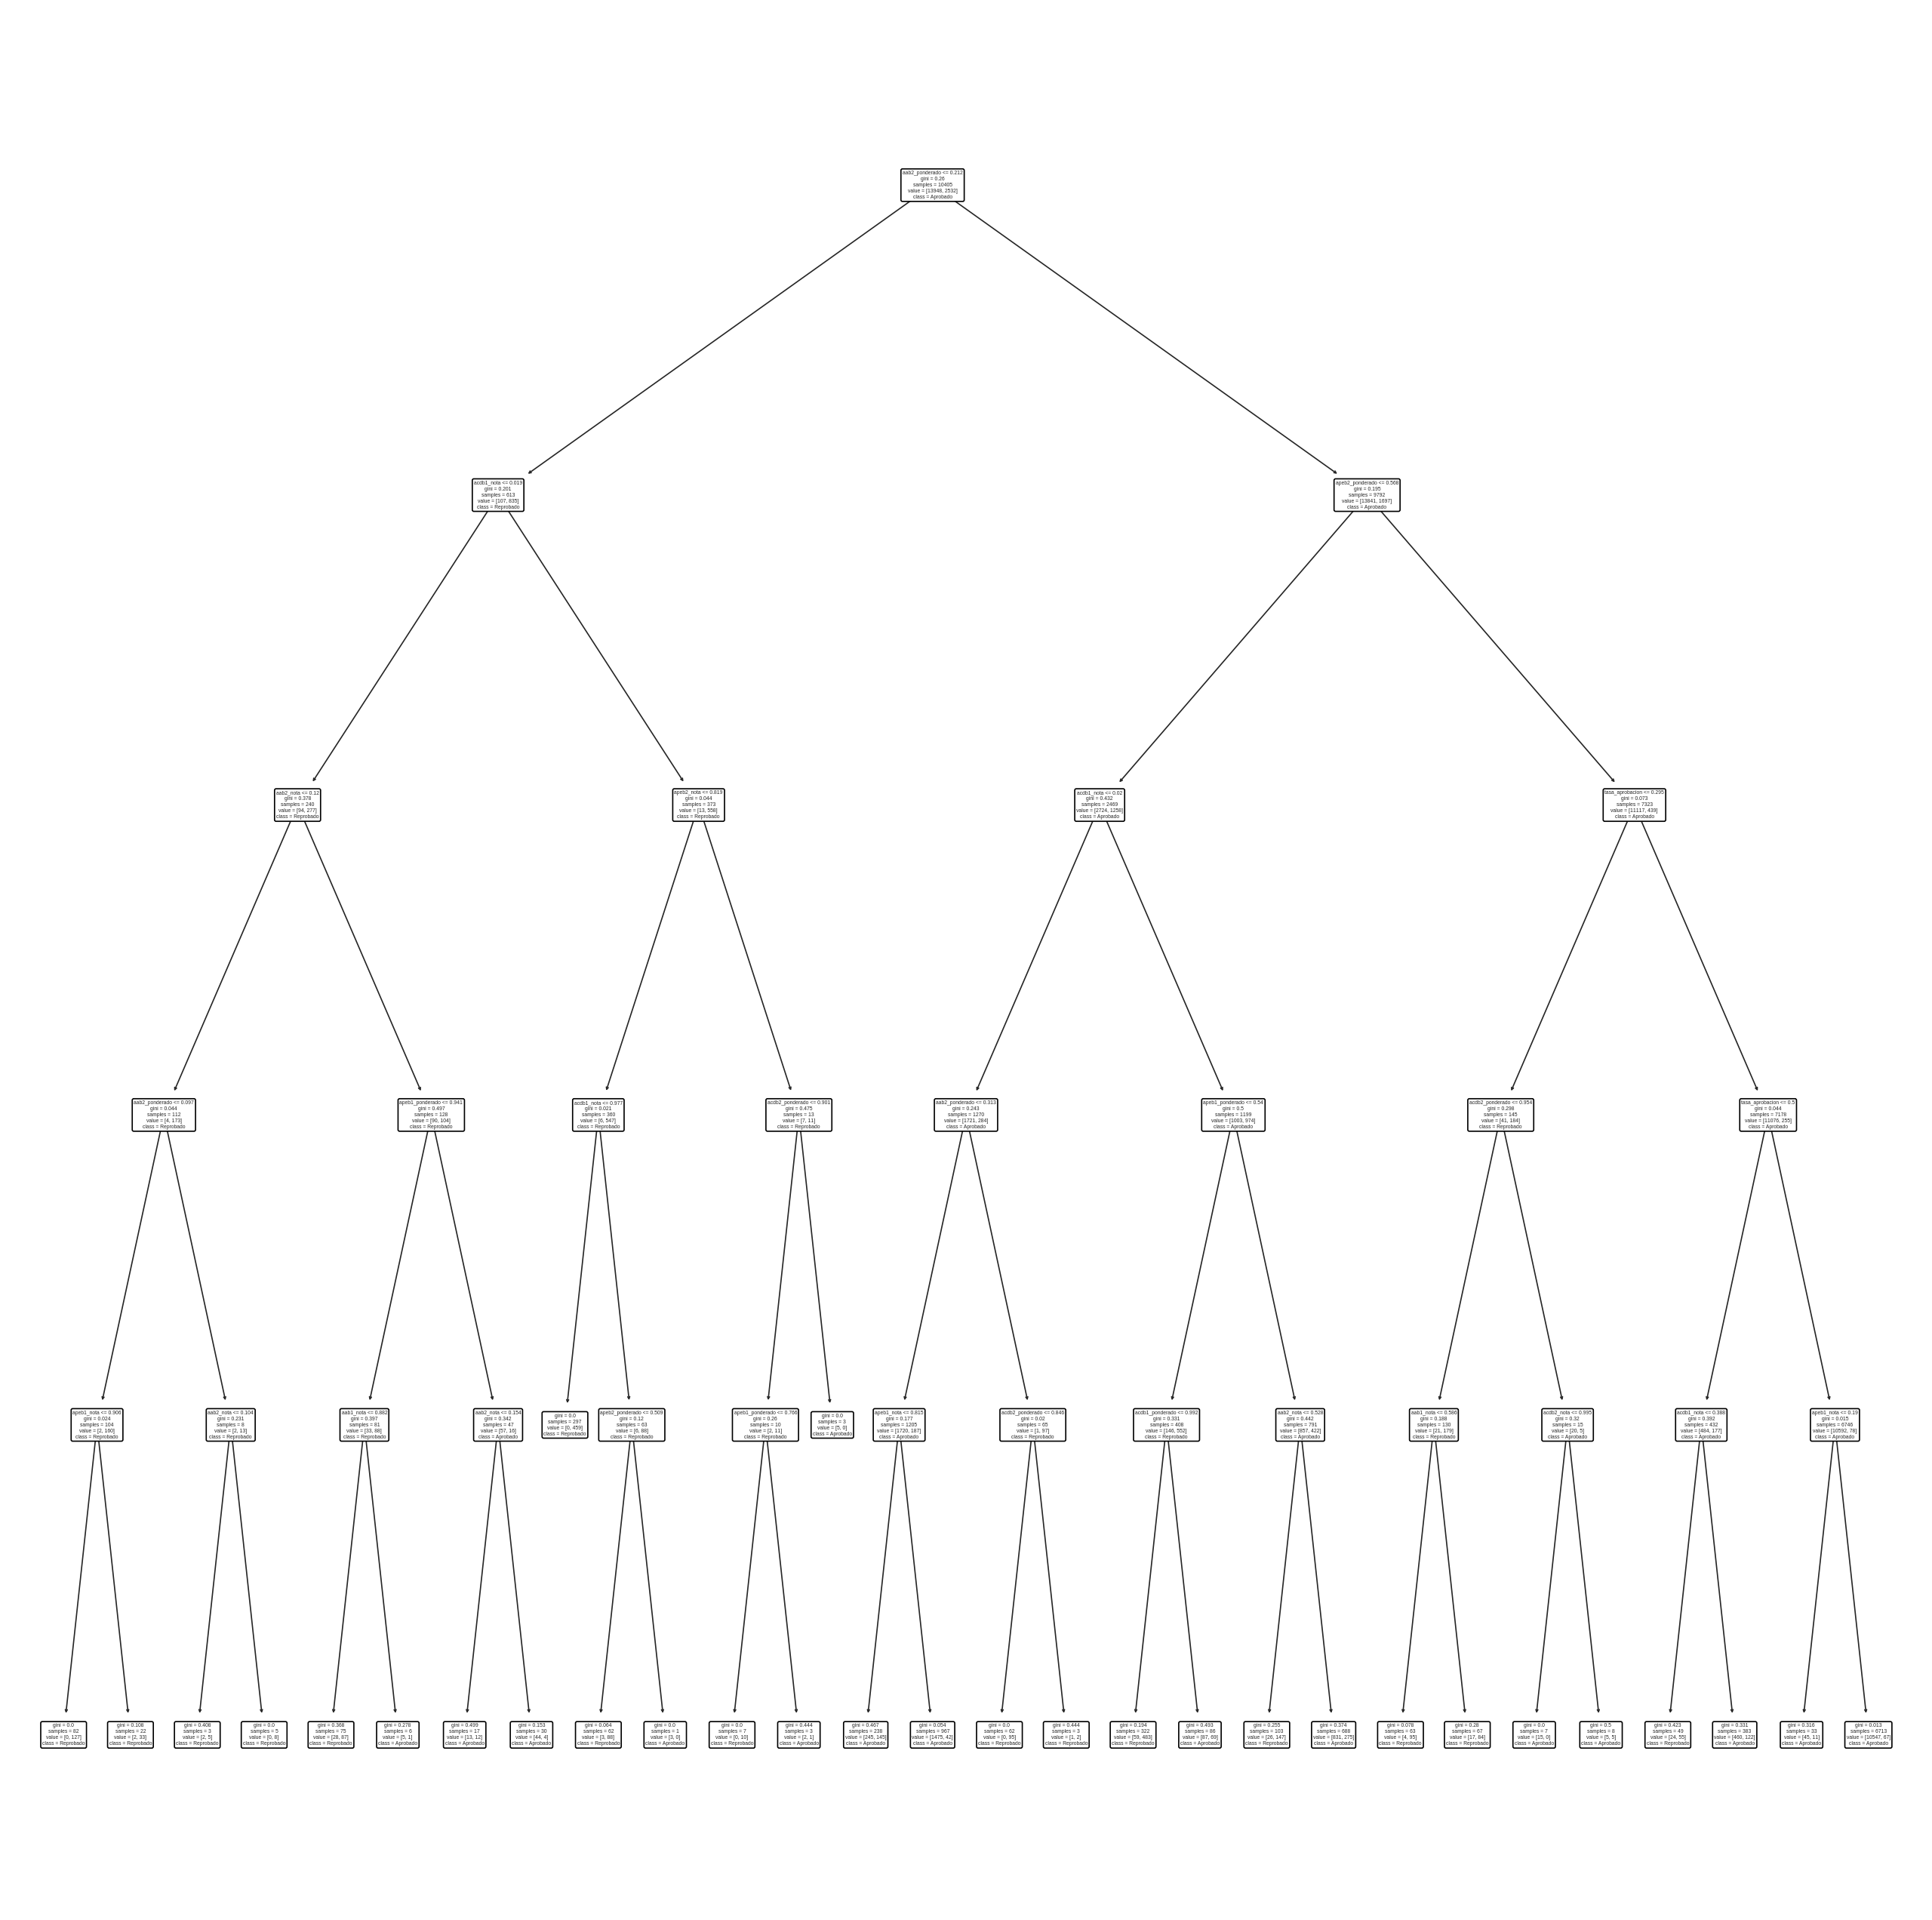

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1,figsize = (8,8), dpi = 400)
tree.plot_tree(
    rand_forest_classifier_model.estimators_[0],
    feature_names = numeric_x_train.columns,
    class_names = ['Aprobado', 'Reprobado'],
    rounded = True
)
fig.savefig('rf_individualtree1.png')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
accuracy = rand_forest_classifier_model.score(numeric_x_train_scaler, numeric_y_train_scaler)
print(f"Precisión del modelo: {accuracy}")

Precisión del modelo: 0.9665655339805825


In [ ]:
from sklearn import metrics

In [ ]:
print(classification_report(numeric_y_test_scaler, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.96      0.99      0.97      5929
   Reprobado       0.92      0.81      0.86      1134

    accuracy                           0.96      7063
   macro avg       0.94      0.90      0.92      7063
weighted avg       0.96      0.96      0.96      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.805996
Reprobado,0.986507


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,6069
Reprobado,1134,994


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

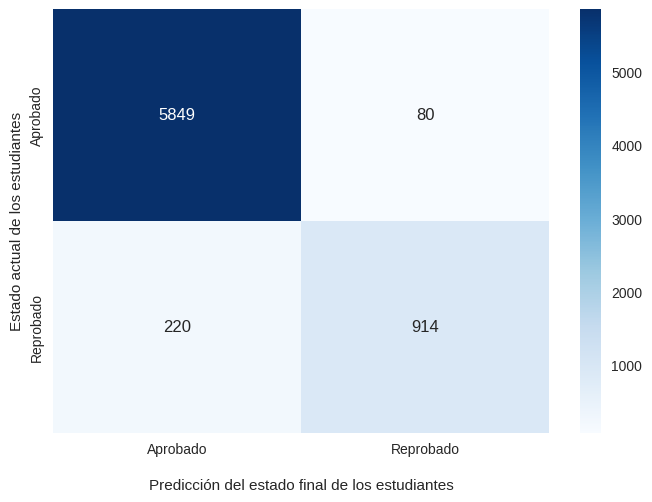

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
from yellowbrick.classifier import ROCAUC

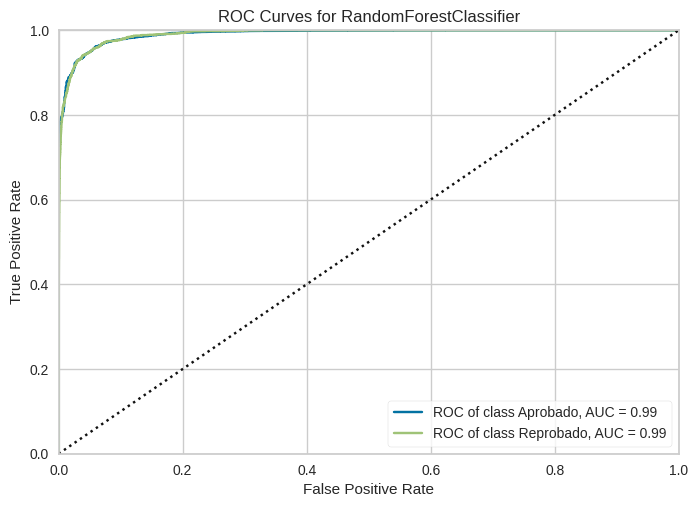

In [ ]:
visualizer = ROCAUC(
    rand_forest_classifier_model,
    macro = False,
    micro = False,
    encoder = {0: 'Aprobado', 1: 'Reprobado'},
)
visualizer.fit(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.score(numeric_x_train_scaler, numeric_y_train_scaler)
visualizer.finalize()

In [ ]:
auc_random_forest = visualizer

## **Modelo 4: Redes Neuronales de Clasificación**

In [ ]:
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
numeric_y_train_array = np.asarray(list(numeric_y_train_scaler))
numeric_y_test_array = np.asarray(list(numeric_y_test_scaler))

In [ ]:
# !rm -rf logs/
# !rm -rf models/

In [ ]:
neural_network_model = Sequential([
    Dense(6, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

neural_network_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

checkpoint_filepath = f'models/checkpoint-neural-network-model.hdf5'
model_chekpoint = ModelCheckpoint(
        filepath = checkpoint_filepath,
        monitor = 'accuracy',
        verbose = 0,
        save_best_only = True,
        mode ='auto',
        save_freq = 1,
        save_weights_only = True
    )

early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1,
    patience = 25
)

log_dir = f'logs/fit/neural-network-model'
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq = 1)

neural_network_model.fit(
    x = numeric_x_train_scaler,
    y = numeric_y_train_array,
    epochs = 2000,
    validation_data = [numeric_x_test_scaler, numeric_y_test_array],
    callbacks = [model_chekpoint, tensorboard, early_stop]
)

predictions = list(itertools.chain(*(neural_network_model.predict(numeric_x_test_scaler) > 0.5).astype('int32')))

Epoch 1/2000
515/515 [==============================] - 8s 10ms/step - loss: 0.4223 - accuracy: 0.8470 - val_loss: 0.3228 - val_accuracy: 0.8394
Epoch 2/2000
515/515 [==============================] - 2s 4ms/step - loss: 0.3516 - accuracy: 0.8470 - val_loss: 0.2991 - val_accuracy: 0.8394
Epoch 3/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.3278 - accuracy: 0.8470 - val_loss: 0.2823 - val_accuracy: 0.8394
Epoch 4/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.3077 - accuracy: 0.8470 - val_loss: 0.2611 - val_accuracy: 0.8394
Epoch 5/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.2900 - accuracy: 0.8470 - val_loss: 0.2414 - val_accuracy: 0.8394
Epoch 6/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.2759 - accuracy: 0.8694 - val_loss: 0.2273 - val_accuracy: 0.9002
Epoch 7/2000
515/515 [==============================] - 2s 3ms/step - loss: 0.2664 - accuracy: 0.9016 - val_loss: 0.2106 - val_accuracy

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
test_loss, test_accuracy = neural_network_model.evaluate(numeric_x_test_scaler, numeric_y_test_array, verbose = 2)
print(f'Precisión del modelo: {test_accuracy}')

221/221 - 0s - loss: 0.1310 - accuracy: 0.9401 - 292ms/epoch - 1ms/step
Precisión del modelo: 0.940110445022583


In [ ]:
print(classification_report(numeric_y_test_array, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.94      0.99      0.97      5929
   Reprobado       0.91      0.69      0.79      1134

    accuracy                           0.94      7063
   macro avg       0.93      0.84      0.88      7063
weighted avg       0.94      0.94      0.94      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.692240
Reprobado,0.987519


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Aprobado
2,Aprobado,Aprobado
3,Reprobado,Reprobado
4,Aprobado,Aprobado
5,Reprobado,Reprobado
6,Aprobado,Aprobado
7,Aprobado,Aprobado
8,Aprobado,Aprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,6204
Reprobado,1134,859


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

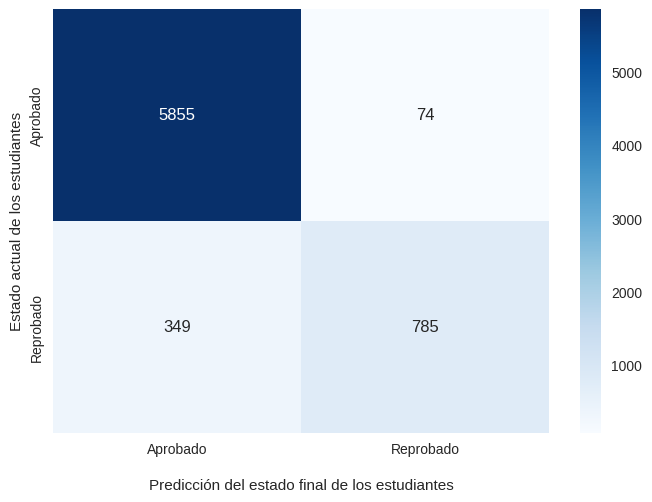

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_scaler, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_keras = neural_network_model.predict(numeric_x_test_scaler)
auc_neural_network_fpr = dict()
auc_neural_network_tpr = dict()
auc_neural_network_roc_auc = dict()
n_classes = 2

for i in range(n_classes):
    auc_neural_network_fpr[i], auc_neural_network_tpr[i], _ = roc_curve(numeric_y_test.ravel(), y_pred_keras.ravel())
    auc_neural_network_roc_auc[i] = auc(auc_neural_network_fpr[i], auc_neural_network_tpr[i])

221/221 [==============================] - 0s 1ms/step


## **Modelo 5: Redes Neuronales de Clasificación Recurrentes - LTSM**

In [ ]:
import numpy as np
import itertools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
numeric_y_train_array = np.asarray(list(numeric_y_train_scaler))
numeric_y_test_array = np.asarray(list(numeric_y_test_scaler))
numeric_x_train_3d = np.resize(numeric_x_train_scaler, (numeric_x_train_scaler.shape[0], 1, numeric_x_train_scaler.shape[1]))
numeric_x_test_3d = np.resize(numeric_x_test_scaler, (numeric_x_test_scaler.shape[0], 1, numeric_x_test_scaler.shape[1]))

In [ ]:
# !rm -rf logs/
# !rm -rf models/

In [ ]:
neural_network_recurreny_model = Sequential([
    Bidirectional(
        LSTM(
            20,
            dropout = 0.6
        )
    ),
    Dense(6, activation = 'relu'),
    Dropout(0.5),
    Dense(2, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

neural_network_recurreny_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

checkpoint_filepath = f'models/recurrent/checkpoint-neural-network-model.hdf5'
model_chekpoint = ModelCheckpoint(
        filepath = checkpoint_filepath,
        monitor = 'accuracy',
        verbose = 0,
        save_best_only = True,
        mode ='auto',
        save_freq = 1,
        save_weights_only = True
    )

early_stop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    verbose = 1,
    patience = 25
)

log_dir = f'logs/recurrent/fit/neural-network-model'
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq = 1)

neural_network_recurreny_model.fit(
    x = numeric_x_train_3d,
    y = numeric_y_train_array,
    epochs = 2000,
    validation_data = [numeric_x_test_3d, numeric_y_test_array],
    callbacks = [model_chekpoint, tensorboard, early_stop]
)

predictions = list(itertools.chain(*(neural_network_recurreny_model.predict(numeric_x_test_3d) > 0.5).astype('int32')))

Epoch 1/2000
515/515 [==============================] - 16s 20ms/step - loss: 0.6215 - accuracy: 0.8322 - val_loss: 0.5626 - val_accuracy: 0.8394
Epoch 2/2000
515/515 [==============================] - 3s 6ms/step - loss: 0.5200 - accuracy: 0.8470 - val_loss: 0.4948 - val_accuracy: 0.8394
Epoch 3/2000
515/515 [==============================] - 3s 6ms/step - loss: 0.4690 - accuracy: 0.8470 - val_loss: 0.4622 - val_accuracy: 0.8394
Epoch 4/2000
515/515 [==============================] - 3s 5ms/step - loss: 0.4440 - accuracy: 0.8470 - val_loss: 0.4368 - val_accuracy: 0.8394
Epoch 5/2000
515/515 [==============================] - 3s 6ms/step - loss: 0.4131 - accuracy: 0.8541 - val_loss: 0.3936 - val_accuracy: 0.8400
Epoch 6/2000
515/515 [==============================] - 3s 6ms/step - loss: 0.3931 - accuracy: 0.8608 - val_loss: 0.3802 - val_accuracy: 0.8402
Epoch 7/2000
515/515 [==============================] - 3s 7ms/step - loss: 0.3816 - accuracy: 0.8627 - val_loss: 0.3361 - val_accurac

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

In [ ]:
test_loss, test_accuracy = neural_network_recurreny_model.evaluate(numeric_x_test_3d, numeric_y_test_array, verbose = 2)
print(f'Precisión del modelo: {test_accuracy}')

221/221 - 0s - loss: 1.7388 - accuracy: 0.1562 - 399ms/epoch - 2ms/step
Precisión del modelo: 0.1561659425497055


In [ ]:
print(classification_report(numeric_y_test_array, predictions, target_names = ['Aprobado', 'Reprobado']))

              precision    recall  f1-score   support

    Aprobado       0.03      0.00      0.00      5929
   Reprobado       0.16      0.97      0.27      1134

    accuracy                           0.16      7063
   macro avg       0.09      0.49      0.14      7063
weighted avg       0.05      0.16      0.04      7063



In [ ]:
mcm = multilabel_confusion_matrix(numeric_y_test_scaler, predictions)
true_negative = mcm[:, 0, 0]
false_positive = mcm[:, 0, 1]
specificiy = true_negative / (true_negative + false_positive)

In [ ]:
metrics = pd.DataFrame({
    'Especificidad': specificiy
}, index=['Aprobado', 'Reprobado'])
metrics

,Especificidad
Aprobado,0.971781
Reprobado,0.000169


In [ ]:
results = pd.DataFrame({
    'status': numeric_y_test.values,
    'status_predicted': predictions
}).replace([0, 1], ['Aprobado', 'Reprobado'])

results.head(10)

,status,status_predicted
0,Reprobado,Reprobado
1,Aprobado,Reprobado
2,Aprobado,Reprobado
3,Reprobado,Reprobado
4,Aprobado,Reprobado
5,Reprobado,Reprobado
6,Aprobado,Reprobado
7,Aprobado,Reprobado
8,Aprobado,Reprobado
9,Reprobado,Reprobado


In [ ]:
import plotly.graph_objects as go

In [ ]:
bar_chart = [
    go.Bar(
        name = 'Valores reales',
        x = ['Aprobado', 'Reprobado'],
        y = results['status'].value_counts()

    ),
    go.Bar(
        name = 'Valores predichos',
        x = ['Aprobado', 'Reprobado'],
        y = results['status_predicted'].value_counts()
    )
]

figure = {
    'data': bar_chart,
    'layout': {
        'xaxis': {
            'title': 'Estado final de los estudiantes',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'yaxis': {
            'title': 'Cantidad de datos',
            'titlefont_size': 16,
            'tickfont_size': 14
        },
        'legend': {
            'x': 0.8, 'y': 1.0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
        'barmode': 'group',
        'bargap': 0.15,
        'bargroupgap': 0.1
    }

}

go.Figure(figure).show()

In [ ]:
pd.concat([
    pd.DataFrame(results['status'].value_counts()),
    pd.DataFrame(results['status_predicted'].value_counts())
], axis=1)

,status,status_predicted
Aprobado,5929,33
Reprobado,1134,7030


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

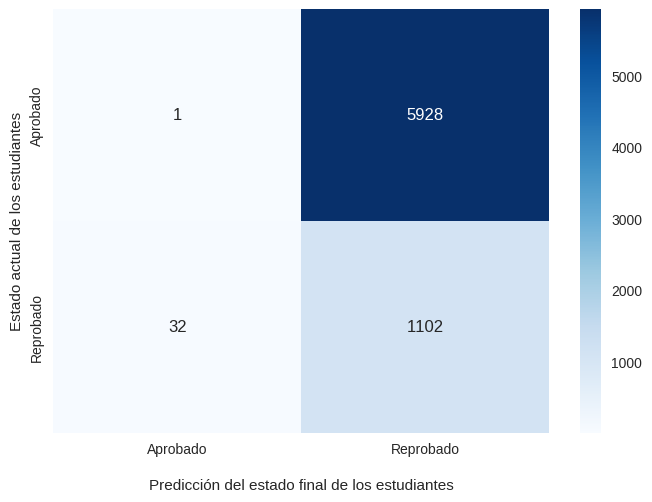

In [ ]:
cf_matrix = confusion_matrix(numeric_y_test_array, predictions)
ax = sns.heatmap(cf_matrix, annot = True, cmap = 'Blues', fmt='d')
ax.set_xlabel('\nPredicción del estado final de los estudiantes')
ax.set_ylabel('Estado actual de los estudiantes');
ax.xaxis.set_ticklabels(['Aprobado', 'Reprobado'])
ax.yaxis.set_ticklabels(['Aprobado', 'Reprobado'])
plt.show()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_keras = neural_network_recurreny_model.predict(numeric_x_test_3d)
auc_neural_network_recurreny_fpr = dict()
auc_neural_network_recurreny_tpr = dict()
auc_neural_network_recurreny_roc_auc = dict()
n_classes = 2

for i in range(n_classes):
    auc_neural_network_recurreny_fpr[i], auc_neural_network_recurreny_tpr[i], _ = roc_curve(numeric_y_test_scaler.ravel(), y_pred_keras.ravel())
    auc_neural_network_recurreny_roc_auc[i] = auc(auc_neural_network_recurreny_fpr[i], auc_neural_network_recurreny_tpr[i])

221/221 [==============================] - 0s 2ms/step


# **Area bajo la curva**

In [ ]:
auc_graphs = [
    go.Scatter(
        showlegend=False,
        x = [0, 1],
        y = [0, 1],
        line={'color': '#000', 'dash': 'dash'},

    ),
    go.Scatter(
        name='Regresión Logística: Clase Aprobado, AUC = %.2f'%(auc_logistic_regression.roc_auc[0]),
        x = auc_logistic_regression.fpr[0],
        y = auc_logistic_regression.tpr[0],
        line = {'color':'#636EFA', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Regresión Logística: Clase Reprobado, AUC = %.2f'%(auc_logistic_regression.roc_auc[1]),
        x = auc_logistic_regression.fpr[1],
        y = auc_logistic_regression.tpr[1],
        line = {'color':'#636EFA'}
    ),
    go.Scatter(
        name='Análisis discriminante lineal: Clase Aprobado, AUC = %.2f'%(auc_lineal_discriminant.roc_auc[0]),
        x = auc_lineal_discriminant.fpr[0],
        y = auc_lineal_discriminant.tpr[0],
        line = {'color':'#EF553B', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Análisis discriminante lineal: Clase Reprobado, AUC = %.2f'%(auc_lineal_discriminant.roc_auc[1]),
        x = auc_lineal_discriminant.fpr[1],
        y = auc_lineal_discriminant.tpr[1],
        line = {'color':'#EF553B'}
    ),
    go.Scatter(
        name='Bosque Aleatorio: Clase Aprobado, AUC = %.2f'%(auc_random_forest.roc_auc[0]),
        x = auc_random_forest.fpr[0],
        y = auc_random_forest.tpr[0],
        line = {'color':'#109618', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Bosque Aleatorio: Clase Reprobado, AUC = %.2f'%(auc_random_forest.roc_auc[1]),
        x = auc_random_forest.fpr[1],
        y = auc_random_forest.tpr[1],
        line = {'color':'#109618'}
    ),
    go.Scatter(
        name='Red Neuronal: Clase Aprobado, AUC = %.2f'%(auc_neural_network_roc_auc[0]),
        x = auc_neural_network_fpr[0],
        y = auc_neural_network_tpr[0],
        line = {'color':'#9467BD', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Red Neuronal: Clase Reprobado, AUC = %.2f'%(auc_neural_network_roc_auc[1]),
        x = auc_neural_network_fpr[1],
        y = auc_neural_network_tpr[1],
        line = {'color':'#9467BD'}
    ),
    go.Scatter(
        name='Red Neuronal Recurrente: Clase Aprobado, AUC = %.2f'%(auc_neural_network_recurreny_roc_auc[0]),
        x = auc_neural_network_recurreny_fpr[0],
        y = auc_neural_network_recurreny_tpr[0],
        line = {'color':'#FFA15A', 'dash': 'dash'}
    ),
    go.Scatter(
        name='Red Neuronal Recurrente: Clase Reprobado, AUC = %.2f'%(auc_neural_network_recurreny_roc_auc[1]),
        x = auc_neural_network_recurreny_fpr[1],
        y = auc_neural_network_recurreny_tpr[1],
        line = {'color':'#FFA15A'}
    ),
]

figure = {
    'data': auc_graphs,
    'layout': {
        'title': 'Area bajo la curva',
        'legend': {
            'x': 0.7, 'y': 0,
            'bgcolor': 'rgba(255, 255, 255, 0)',
            'bordercolor': 'rgba(255, 255, 255, 0)'
        },
        'xaxis': {
            'title': 'Tasa de falsos positivos'
        },
        'yaxis': {
            'title': 'Tasa de verdaderos positivos'
        },
        'paper_bgcolor': 'rgba(255, 255, 255, 0)',
    }
}

go.Figure(figure).show()

# **Resumen de resultados**

| | Regresión Logística | Análisis Discriminante Lineal | Bosque aleatorio | Redes Neuronales de Clasificación | Redes Neuronales Recurrentes |
|----------------------- | ----- | ----- | --------- | ----- | ----- |
| **Precisión**          | 0.880 | 0.870 | **0.940** | 0.925 | 0.095 |
| **Sensibilidad**       | 0.820 | 0.820 | **0.900** | 0.839 | 0.485 |
| **Especificidad**      | 0.822 | 0.820 | 0.896     | **0.975** | 0.485 |
| **F-Score**            | 0.850 | 0.840 | **0.915** | 0.880 | 0.135 |
| **Area bajo la curva** | 0.960 | 0.960 | **0.990** | 0.980 | 0.840 |